# Derived Measurements
From layer profiles we calculate image derived parameters. We'll start by generating some layers, and applying them to 
quantitative maps.

Taking the average of the outer layers
 is analogous to taking the average of the cortex, similarly taking the average of the inner layer is analogous to taking the average of the medulla. Finally we can calculate the gradient of the central profile which gives information about the cortico-medullary difference. To make things easier, the qlayers package has a helper function to do all this in one go. We're going to use the outer 5 mm of tissue as the outer region and tissue deeper than 15 mm as the inner region. You can set the unit argument to percent to use, for example, the outer 10 % and inner 10 % to define the regions and thus control for kidney size.

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns

from qlayers import QLayers, cortical_thickness, slope

sns.set()


def show_slice(img, slice, ax, cmap='gray', clim=None):
    if type(img) is str:
        img = nib.load(img)
    data = img.get_fdata()
    sl = data[:, :, slice]
    if clim is None:
        clim = (sl.min(), sl.max())
    ax.imshow(sl.T, origin='lower', cmap=cmap, clim=clim)
    ax.axis(False)


mask_img = nib.load('data/kidney_mask.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
r2star_map = nib.load('data/r2star.nii.gz')
t1_map = nib.load('data/t1_registered.nii.gz')
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:12<00:00,  4.03s/it]
D:\ppzajd\NextCloud\University\Renal Imaging\Layers\qlayers\qlayers\quant_layers.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_long = pd.concat([self.df_long, sub_df])


In [3]:
grads = slope(qlayers, outer=5, inner=15, unit='mm')
print(f"Average Outer R2* = {grads.loc['r2star', 'outer']:.2f} +/- {grads.loc['r2star', 'outer_std']:.2f} Hz")
print(f"Average Inner R2* = {grads.loc['r2star', 'inner']:.2f} +/- {grads.loc['r2star', 'inner_std']:.2f} Hz")
print(f"Average R2* Grad  = {grads.loc['r2star', 'grad']:.2f} +/- {grads.loc['r2star', 'grad_se']:.2f} Hz/mm")
grads_percent = slope(qlayers, outer=10, inner=90, unit='percent')
grads

Average Outer R2* = 14.55 +/- 13.90 Hz
Average Inner R2* = 25.54 +/- 9.26 Hz
Average R2* Grad  = 1.35 +/- 0.04 Hz/mm


,inner,outer,grad,inner_std,outer_std,grad_se
r2star,25.53684,14.551717,1.346764,9.255501,13.895094,0.037007
t1,1807.865845,562.812836,75.834275,558.441981,838.029864,2.391022


## Working with Tissues and Layers
We can

In [4]:
tissue_img = nib.load('data/tissue.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
qlayers.add_tissue(tissue_img, ['Cortex', 'Medulla'])
# qlayers.add_map(r2star_map, 'r2star')
# qlayers.add_map(t1_map, 't1_registered')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:12<00:00,  4.01s/it]


array([0., 1., 2.])

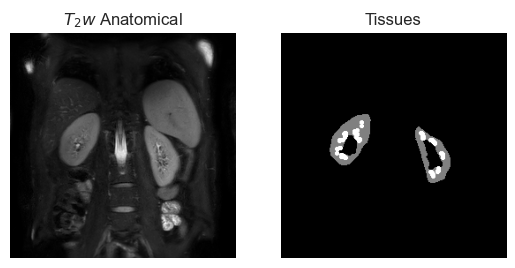

In [5]:
t2w_img = nib.load('data/t2w.nii.gz')
fig, ax = plt.subplots(1, 2)
sl = 7
show_slice(t2w_img, sl, ax[0])
ax[0].set_title('$T_2w$ Anatomical')
show_slice(tissue_img, sl, ax[1])
ax[1].set_title('Tissues')
tissue = tissue_img.get_fdata()
np.unique(tissue)

D:\ppzajd\NextCloud\University\Renal Imaging\Layers\qlayers\qlayers\quant_layers.py:244: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cortex' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df_wide.loc[
D:\ProgramData\Anaconda2\envs\qlayers\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
D:\ProgramData\Anaconda2\envs\qlayers\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\ProgramData\Anaconda2\envs\qlayers\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

Text(0, 0.5, 'Voxel Count')

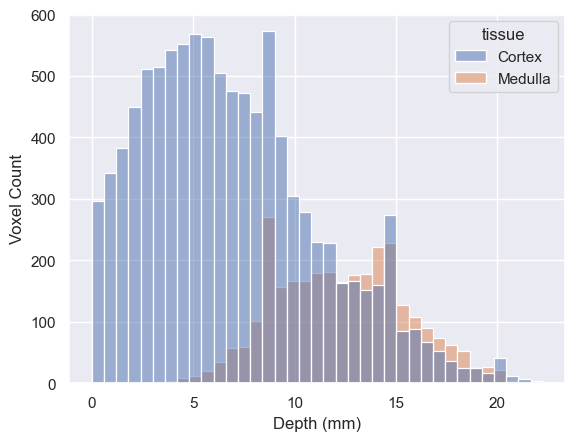

In [6]:
thickness = cortical_thickness(qlayers)
fig, ax = plt.subplots()
sns.histplot(qlayers.get_df('wide'), x='depth', hue='tissue', ax=ax)
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('Voxel Count')

In [7]:
df = qlayers.get_df('wide')
df.loc[df['tissue'] == 'Medulla'].sort_values('depth').head(100)

,depth,layer,tissue
11759,3.637610,4.0,Medulla
11753,3.823703,4.0,Medulla
11747,3.981917,4.0,Medulla
11528,4.035546,5.0,Medulla
24370,4.274223,5.0,Medulla
...,...,...,...
23370,6.881087,7.0,Medulla
21516,6.899412,7.0,Medulla
21184,6.909142,7.0,Medulla
23307,6.912162,7.0,Medulla
